In [1]:
%load_ext autoreload
%env SPARK_HOME=/usr/hdp/current/spark2-client

import findspark
findspark.init()
print('findspark initialized ...')

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col, column, max, min

env: SPARK_HOME=/usr/hdp/current/spark2-client
findspark initialized ...


In [2]:
def initspark():
    spark = SparkSession.builder.appName('mlonspark')\
        .config('spark.executor.instances', '3')\
        .getOrCreate()
    print('pyspark ready ...')
    return spark

In [3]:
from pyspark.ml.recommendation import ALS
def initalg(val):
    return ALS()\
    .setUserCol("userId")\
    .setItemCol("artistId")\
    .setRatingCol("stdCountPos")\
    .setRank(25)\
    .setRegParam(0.0)\
    .setAlpha(10.0)\
    .setMaxIter(val)\
    .setImplicitPrefs(True)


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot(res):
    x = []
    yTrain = []
    yTest = []
    for v in res:
        x.append(v[0])
        yTrain.append(v[1])
        yTest.append(v[2])

    plt.figure(figsize=(8,4))
    plt.plot(x, yTrain, "g-", linewidth=2, label=r"$TRAIN$")
    plt.plot(x, yTest, "r:", linewidth=2, label=r"TEST")
    plt.legend(loc="upper left", fontsize=15)
    plt.ylabel("RMSE", fontsize=18)

In [5]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import isnan

def runtest(rng, **model_kargs):
    res = []
    for i in rng:
        spark = initspark();
        train = spark.read.load("/data/lastfm-dataset-360K/data-filtered-std-pos-train.parquet")
        test = spark.read.load("/data/lastfm-dataset-360K/data-filtered-std-pos-test.parquet")
        
        evaluator = RegressionEvaluator()\
            .setMetricName("rmse")\
            .setLabelCol("stdCountPos")\
            .setPredictionCol("prediction")
        
        alg = initalg(i)
        model = alg.fit(train)
        trainPredictions = model.transform(train)
        trainPredictionsFiltered = trainPredictions.where(~isnan(col("prediction")))  
        trainRmse = evaluator.evaluate(trainPredictionsFiltered)
        
        
        testPredictions = model.transform(test)
        testPredictionsFiltered = testPredictions.where(~isnan(col("prediction")))    
        
        
        testRmse = evaluator.evaluate(testPredictionsFiltered)
        
        
        res.append([i, trainRmse, testRmse])
        plot(res)
        spark.stop()
    return res

pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
[[1, 1.2648849009124783, 1.3368969752651365], [2, 1.1571176177934606, 1.2101394429478296], [3, 1.1389696761618675, 1.181963551724003], [4, 1.1333669248362825, 1.1721883646776798], [5, 1.1311687139531243, 1.1682459911238208], [6, 1.130127600690668, 1.1664291519912877], [7, 1.1295534423046327, 1.165474562499133], [8, 1.1292018416964968, 1.1649206674942478], [9, 1.1289713801222823, 1.1645763617726435]]


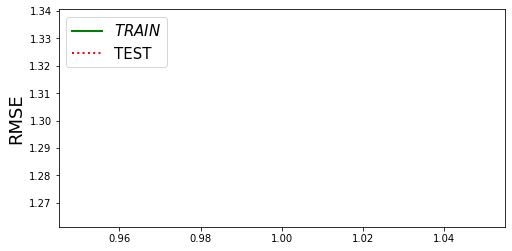

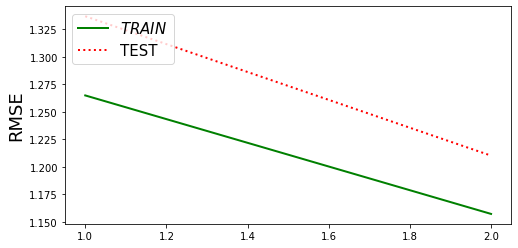

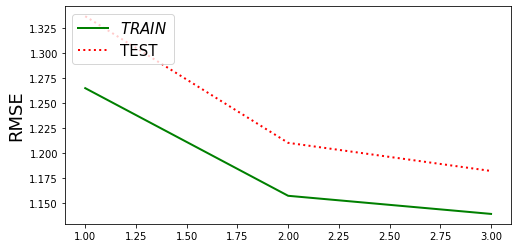

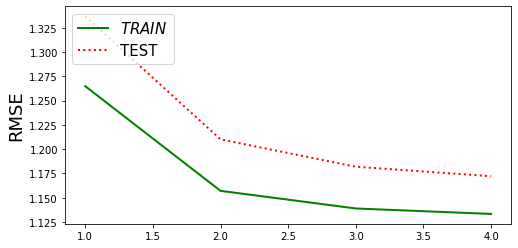

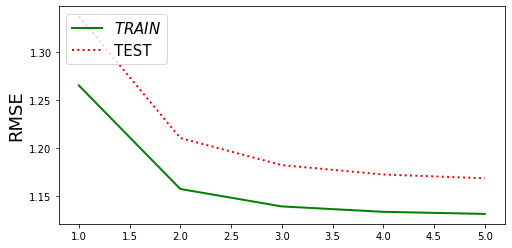

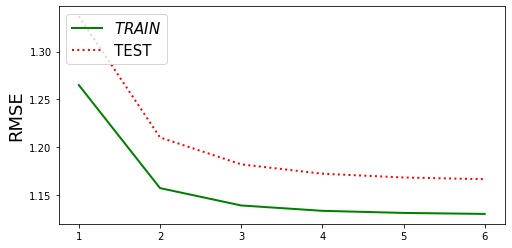

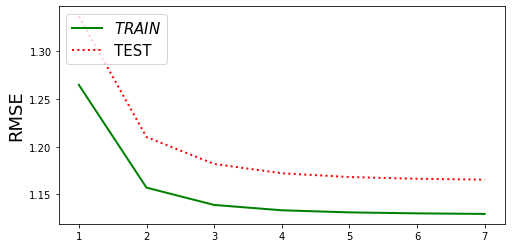

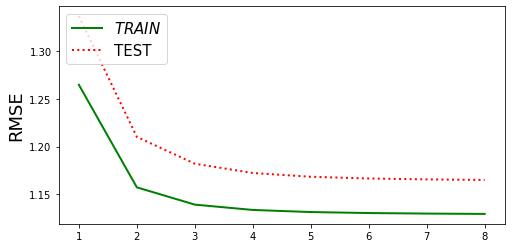

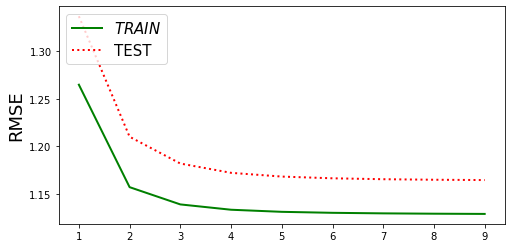

In [6]:
%matplotlib inline

import numpy as np
rng = np.arange(1, 10, 1).tolist()
res = runtest(rng)
print(res)

In [7]:
x = []
yTrain = []
yTest = []
for v in res:
    x.append(v[0])
    yTrain.append(v[1])
    yTest.append(v[2])

print(yTest)

[1.3368969752651365, 1.2101394429478296, 1.181963551724003, 1.1721883646776798, 1.1682459911238208, 1.1664291519912877, 1.165474562499133, 1.1649206674942478, 1.1645763617726435]


Text(0, 0.5, 'RMSE')

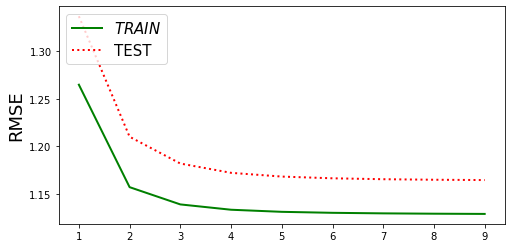

In [8]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(x, yTrain, "g-", linewidth=2, label=r"$TRAIN$")
plt.plot(x, yTest, "r:", linewidth=2, label=r"TEST")
plt.legend(loc="upper left", fontsize=15)
plt.ylabel("RMSE", fontsize=18)